# First test

In [107]:
# import required libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

What is probabilistic programming languages (PPL)?


What would we use probabilistic programming languages for? 
Inference
when and why would it be better than the standard approach

probabilistic models
conditioning overwrites the other statements that sample - why this

## Propagate Single Particle
A simple example is a model that propagates a single particle forward in time. We want to infer the speed of propagation. The speed of propagation is drawn from a normal prior, with a prior guess and some variance. From this, the position can be calculated, which is observed with some measurement error.

$${\sf speed} \, | \, {\sf guess} \sim \cal {\sf Normal}({\sf guess}, 1) $$
$$ {\sf position}_{\sf final} = {\sf position}_{\sf initial} + {\sf speed}\times{\sf time}$$
$${\sf position}_{\sf observed} \, | \, {\sf guess}, {\sf speed} \sim {\sf Normal}({\sf position}_{\sf final}, 0.01)$$

Speed is a latent random variable we want to infer. The function for this model is written below:

In [150]:
pyro.clear_param_store()
def propagate(guess=1.,position_0=0.75,time=0.625):
    """ Parameters:
    guess = the user's guess for the speed
    position_0 = initial position 
    time = length of time before observing """
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(guess, 0.25))
    # final conditions: wave peak at init - c(dt/dx)*NT
    position_f = position_0 + speed * time
    # final position is observed with a bit of noise
    position_obs = pyro.sample("position",dist.Normal(position_f,0.01))
    # If we wanted this to be the exact position, we could use
    #position_obs = pyro.sample("position",dist.Delta(position_f))
    return(speed,position_obs)




Check this function works by running it 5 times.

In [151]:
# Check this gives a different position wave every time depending on the speed sampled
for i in range(5):
    speed,pos=propagate()
    print("speed=",speed,", position=",pos)


speed= tensor(0.6963) , position= tensor(1.1819)
speed= tensor(0.5633) , position= tensor(1.0908)
speed= tensor(0.8004) , position= tensor(1.2528)
speed= tensor(0.9588) , position= tensor(1.3599)
speed= tensor(1.1580) , position= tensor(1.4789)


Plot a histogram to check this function returns a different speed and position each time.

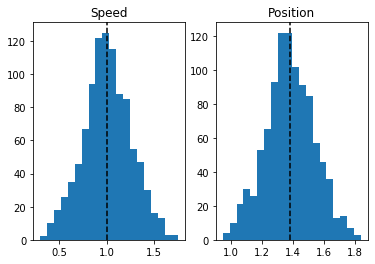

In [152]:
uncond = [propagate() for i in range(1000)]
speed_uncond,pos_uncond = zip(*uncond)
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_uncond,20);
ax1.axvline(np.mean(speed_uncond),c="k",ls="--");
plt.title('Speed');
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(pos_uncond,20);
ax2.axvline(np.mean(pos_uncond),c="k",ls="--");
plt.title('Position');

## Conditioning
We observe the particle at a certain value and put this into the function to create the conditioned version of the function. The condition function in pyro returns a new function (conditioned_propagate) where the position is fixed at the observed value and no longer has to be sampled. The rest of the function remains the same as propagate, with the speed being drawn from the normal distribution as before.

In [153]:
position_observed = 1.8
conditioned_propagate = pyro.condition(propagate,
                                       data={"position": position_observed})

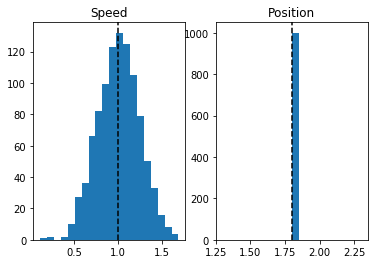

In [154]:
# Check this gives the same position wave every time 
# but a different speed
cond = [conditioned_propagate() for i in range(1000)]
speed_cond,pos_cond = zip(*cond)
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_cond,20);
ax1.axvline(np.mean(speed_cond),c="k",ls="--");
plt.title('Speed');
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(pos_cond,20);
ax2.axvline(np.mean(pos_cond),c="k",ls="--");
plt.title('Position');

## Guide
The aim is to find the posterior distribution of the latent variables of the model (speed), given the model and the observations.

$$({\sf speed} \, | \, {\sf guess}, {\sf position}_{\sf observed}  = 1.8) \sim \, ? $$


In some scenarios there may be an analytical form of this distribution. But if not, we can use the stochastic variational inference algorithm. This requires a distribution that approximates the posterior distribution, which is called the variational distribution or "guide". This function relies on additional parameters called variational parameters, that will be tuned to move the guide towards the posterior distribution. 

For this example, the speed is sampled from a normal distribution with mean and variance given by the variational parameters, a and b. The initial values of a is the guess and the initial value of b is 1. These parameters will be optimised in stochastic variational inference. Also note that the variance, b, is constrained to be positive.

In [155]:
from torch.distributions import constraints
def guide(guess=1.):
    """ The guide (or variational distribution) approximates 
    the posterior distribution, using extra variational parameters,
    a and b, to sample from the speed distribution. """
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), 
                   constraint=constraints.positive)
    speed = pyro.sample("speed", dist.Normal(a,b))
    return speed

We can plot some samples from the guide, in the same way as before. Note that the guide returns the speed as a tensor (hence the  `.item()` to get the values for the histogram).

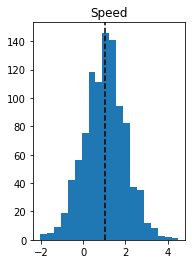

In [156]:
# Check guide distribution by running this function 1000 times
pyro.clear_param_store()
speed_guide = [guide().item() for i in range(1000)]
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
plt.title('Speed');

## Pyro Parameters
In the guide, we created Parameters in Pyro using `pyro.param("parameter_name", torch.tensor(parameter_value))`.
These are are thin wrappers around PyTorch Tensors with unique names (see http://docs.pyro.ai/en/0.2.1-release/parameters.html). They are saved in the Pyro Parameter Store, a dictionary of the parameters stored:

In [157]:
param_store = pyro.get_param_store()
print(param_store)
print(param_store.keys())

dict_keys(['a', 'b'])


The values of the parameters can be accessed using the unique parameter names. 

In [158]:
a = param_store.get_param("a")
print(a)

tensor(1., requires_grad=True)


As expected, the value of parameter `a` is the value provided in the guide function. This value can be replaced using the `.replace_param` function.  

In [159]:
param_store.replace_param("a",torch.tensor(2.),a)
a = param_store.get_param("a")
print(a)

tensor(2., requires_grad=True)


Now when we call the guide function, the new value of the parameter is used. The line 

`a = pyro.param("a", torch.tensor(guess))`

inside the guide function will not affect the value of the parameter. This can be checked by sampling from the guide many times.

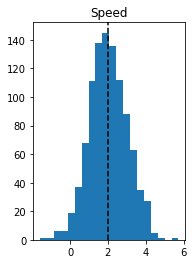

In [160]:
speed_guide = [guide().item() for i in range(1000)]
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
plt.title('Speed');

This process is used in the stochastic variational inference, where the parameters are updated in the parameter store at each step, rather than explicitly changing the guide function at each step. Finally, we can reset the values of the parameters using `pyro.clear_param_store()`. 

In [161]:
pyro.clear_param_store()
param_store = pyro.get_param_store()
print(param_store.keys())

dict_keys([])


## Stochastic Variational Inference
We have created a family of guide functions, indexed by named parameters, and want to search for the member of that family that is the best approximation to the posterior distribution, according to some loss function. We use stochastic variational inference , `pyro.infer.SVI`, to optimise the parameters of the guide so that sampling from the guide produces a distribution for `speed` consistent with the model conditioned on observations. 
The ELBO can be used as a loss function (currently the only loss function that can be used in Pyro).

7335.984982252121


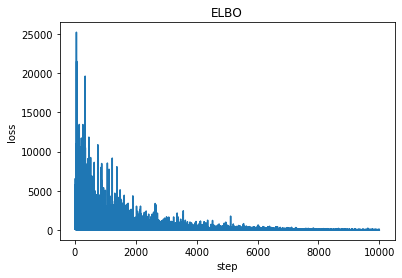

In [168]:
pyro.clear_param_store()

from pyro.optim import Adam
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())
print(svi.step())

losses, a,b  = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


a =  1.6776763200759888
b =  0.07344074547290802


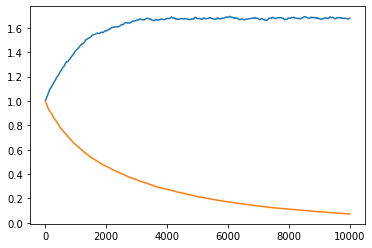

In [169]:
print('a = ',pyro.param("a").item())
print('b = ',pyro.param("b").item())

plt.plot(a);
plt.plot(b);

Once converged, we have a value of `a` and `b` that can be used in the guide to sample from the speed given the model and the observations. This is an approximation to the posterior distribution. We can also compare this to the analytic speed, which can be calculated for this simple example:

In [170]:
# compare against analytic speed
peak_0 = 0.75
nt = 25    
dt = .025
speed_analytic = (position_observed - peak_0)/(nt*dt)
print(speed_analytic)

1.6800000000000002


In [171]:
param_store = pyro.get_param_store()
print("Speed | model, obs ~ N({:.2f},{:.2f})".format(
    (param_store.get_param("a").item()),
    (param_store.get_param("b").item() ) ))

Speed | model, obs ~ N(1.68,0.07)


In [172]:
def perfect_guide(guess=1.,position_0=0.75,time=0.625):
    pos_speed = (1.8 - position_0)/time
    v = 0.01/time
    loc =(v**2 * guess + 0.25**2 * pos_speed) / (0.25**2 + v**2) # 1.677
    sd = np.sqrt(v**2/(0.25**2 + v**2)) # 0.0639
    return pyro.sample("speed", dist.Normal(loc, sd))
perfect_guide()

tensor(1.6757)

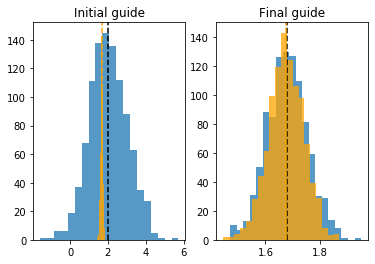

In [177]:
new_speed_guide = [guide().item() for i in range(1000)]
exact_guide = [perfect_guide().item() for i in range(1000)]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20,alpha=0.75);
ax1.axvline(np.mean(speed_guide),c="k",ls="--");
ax1.hist(exact_guide,20,color="orange",alpha=0.75);
ax1.axvline(1.677,c="orange",ls="--");
plt.title('Initial guide')
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(new_speed_guide,20,alpha=0.75);
ax2.axvline(np.mean(new_speed_guide),c="k",ls="--");
ax2.hist(exact_guide,20,color="orange",alpha=0.75);
ax2.axvline(1.677,c="orange",ls="--");
plt.title('Final guide');

There's also an auto-guide option in pyro.

In [188]:
import pyro.contrib
from pyro.contrib.autoguide import AutoDiagonalNormal
autoguide = AutoDiagonalNormal(conditioned_propagate)
svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=autoguide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

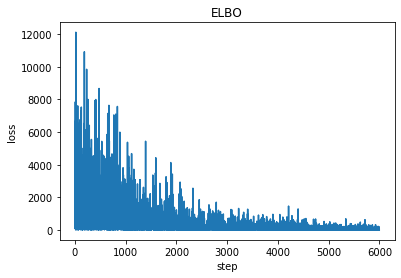

In [192]:
num_steps = 6000
losses = []
for t in range(num_steps):
    losses.append(svi.step())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [193]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

a tensor(1.6723, requires_grad=True)
b tensor(0.0521, grad_fn=<AddBackward0>)
auto_loc tensor([1.6727], requires_grad=True)
auto_scale tensor([0.1563], grad_fn=<AddBackward0>)
